# Detect handwritten digits using simple neural network

Given an image of a handwritten digit stored as pixel values, build a model that can correctly identify the digit. 

We are implementing the process described in Chapter 1 of the book Introduction to Deep Learning by Eugene Charniak. 
After cleaning the data we perform a forward pass to compute the accuracy, then we perform backward pass to update the parameters. We repeat the process until the improvement in the accuracy from one forward pass to the next falls below a threshold. The accuracy of the final forward pass through the training set is the accuracy we report. We then use the model parameters obtained from the last backward pass to perform one forward pass on the validation set and compute the accuracy as a final check. If the accuracy on the training set and validation set is adequate we can say that our model is good. 


## 1. Data Preparation and Transformation

**1.1. Install Mnist dataset from Keras (http://yann.lecun.com/exdb/mnist/)** 
Dataset has 60000 samples in the training set and 10000 samples in the validation set.  

Input: each image of a digit is stored in 28 by 28 matrix of pixel values ranging from 0 to 255

Output: actual value of each image is stored as the digit itself with 10 classes (possible outcomes) {0,1,2,...8,9}. 

We are interested in finding the model parameters (biases and weights), which maps the input variables to a class label (0 to 9 digits). Hence, we will build separate model for each possible outcome, where the model outputs the probability of an example belonging to each possible outcome. 


**1.2. Flatten input data** 

To simply the model, reshape two dimensional matrix (28, 28) into one dimensional array (784,)

**1.3. Normalize input data** 

Divide each value in the input array by the maximum value in the input array so that the values range from 0 to 1

**1.4. Flatten output data** 

Initialize the expected value as an array of 10 binary elements, 0 or 1 



In [1]:
# Get mnist dataset from Keras
# pip install keras tensorflow
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras.datasets import mnist
import sklearn 
from sklearn import metrics
from collections import Counter 
import sys
import random

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_validate, y_validate) = mnist.load_data()

In [3]:
# 60000 samples in the training set 
print( "Dimension of input data in training set:", x_train.shape)
print( "Dimension of output data in training set:", y_train.shape)

Dimension of input data in training set: (60000, 28, 28)
Dimension of output data in training set: (60000,)


In [4]:
# 60000 samples in the training set 
print( "Dimension of input data in validation set:", x_validate.shape)
print( "Dimension of output data in validation set:", y_validate.shape)

Dimension of input data in validation set: (10000, 28, 28)
Dimension of output data in validation set: (10000,)


In [5]:
def plt_digit(single_x):
    """
    Visualize the input data
    """
    if single_x.shape[0] == 784:
        single_x = single_x.reshape(28,28)
    else:
        single_x = single_x
    plt.figure(figsize = (5,5))
    return plt.imshow(single_x, cmap="Greys")

Plot an Example of Input values


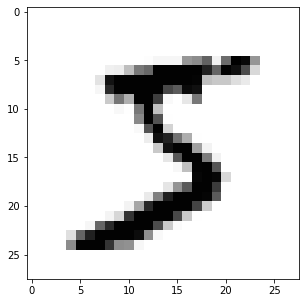

In [6]:
print("Plot an Example of Input values")
plt_digit(x_train[0])

In [7]:
def normalize_x(x_data, size1, size2):
    new_data = x_data.reshape(size1, size2).astype('float32') #flatten input data
    new_data /= np.max(x_data) #normalize input data
    return new_data

x_train_updated = normalize_x(x_train, 60000, 784)
x_validate_updated = normalize_x(x_validate, 10000, 784)

def flatten_y(y_data):
    n_classes = len(Counter(y_data).keys()) # number of possible outcomes
    new_y_data = keras.utils.to_categorical(y_data, n_classes) #flatten output data
    return new_y_data

y_train_updated = flatten_y(y_train)
y_validate_updated = flatten_y(y_validate)

print("Example of output value:", y_train[0])
print("Example of flattened output value:", y_train_updated[0])


Example of output value: 5
Example of flattened output value: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [8]:
n_train = x_train_updated.shape[0]
n_input = x_train_updated.shape[1]
n_output = y_train_updated.shape[1]

print("Number of training examples:", n_train)
print("Number of inputs in each training example:", n_input)
print("Number of classes:", n_output)

# check the number of occurances of each digits
def count_unique(data):
    unique, counts = np.unique(np.array(data), return_counts=True)
    return dict(zip(unique, counts))

#print(count_unique(x_train))

print("Number of occurances of each possible outcome\n", count_unique(y_train))
print("Number of occurances of 0 must be equal to the number of training examples times number of classes minus 1, and 1 must be equal to the number of examples\n", count_unique(y_train_updated))

# sanity check
# (x_train_updated[0] == x_train_updated[1]).all()

Number of training examples: 60000
Number of inputs in each training example: 784
Number of classes: 10
Number of occurances of each possible outcome
 {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Number of occurances of 0 must be equal to the number of training examples times number of classes minus 1, and 1 must be equal to the number of examples
 {0.0: 540000, 1.0: 60000}


## 2. Forward Pass

Initialize parameters and make prediction using softmax function
 

**2.1. Initialize biases and weights** 

Randomly select values close to zero.
      
      number of biases = number of outputs = 10
      number of weights = number of outputs times number of inputs = 10 * 784
      

**2.2. Calculate logit function**   

logit is a term for an un-normalized number that we are about to turn into probabilities using  softmax


      pre_logit = bias + sum(weight*input)
      number of logits for a single sample =  10
      number of logits for all samples =  10 * n_samples
      
      
**2.3. Calculate Softmax**

Softmax is an activation function that converts the pre_logits (unnormalized numbers) into probabilities
        
        pre_logit = {pre_logit_0, pre_logit_1,..., pre_logit_9}
        softmax_j = exp(pre_logit_j)/sum(exp(pre_logit))
        where j is the jth element in pre_logit

We get 10 softmax outputs for each training example. Each softmax output is associated with the 10 possible outcomes.  

**2.4. Predicted value**

Model's prediction for each example is whichever possible outcome has the highest softmax output


**2.5. Compute accuracy**

Percentage of training set, where the model predicted the outcome correctly


## 3. Backward Pass

Update parameters (weights and biases) based on optimization of loss function.  

**3.1. Calculate model error using loss function**

We will use cross-entropy, a common type of loss function used in a classification problem.
Categorical cross entropy is defined as the negative of the sum of product of ground truth times log of the softmax output. 
        
Let $X(\phi)$ be cross-entropy loss function, then for a single example x we have

$X(\phi, x) = -sum(y_i*log(p_i)$ 

where, i is ith index of output y 

Since y_i is 1 for ground truth and 0 otherwise, we can simply the formula as follows:

$X(\phi, x) = -log(p_a)$  

where, a represents the position of the softmax output of the ground truth
        

**3.2. Calculate gradient of the loss function**

We will use gradient descent to optimize our Neural Network model. We update the parameters in the opposite direction of the gradient of the loss function w.r.t. to the parameters (biases  and weights). 
We have to decide how much data to use to compute the gradient of the function. The decision makes a trade-off between the accuracy of the parameter update and the time it takes to perform an update. There are three ways to do the trade-off. They use different methods to break down the process of making a backward pass through the entire training set. A pass through the entire training set is known as an epoch.   

1. Full-batch gradient descent 

Here, we calculate the gradients for the whole dataset then use the updated the parameters for the next epoch (an epoch is one cycle through the full training dataset). Full-batch GD makes vectorization slow and much less efficient as large datasets often can't be held in memory. The advantage of this method is it gives optimal solution given sufficient time to converge. 

2. Stochastic gradient descent

We calculate the gradients for each training example then use the updated the parameters for the next training example. For each epoch, we update the parameters N times, where N is the number of training examples. Stochastic gradient descent causes the loss function to fluctuate heavily since a single example can be noisy and the parameters are updated in each example. The noiseness helps us escape from local minima hence this method gives good but not optimal solution. It's disadvantage is that you need to loop over the entire dataset many number of times to get a good prediction.  

3. Mini-batch gradient descent

This method strikes a balance between the full-batch GD and SGD. We calculate the gradients for every mini-batch of n training examples. It is faster and less computationally expensive than full-batch GD, and lead to more stable convergence than SGD as it reduces the variance of the parameter updates. Therefore, we will use mini-batch GD as our optimization algorithm. We will split the data into batches of size 100 each. 

    60000 images into batch size of 100
   

For each batch

**1.1. Take partial derivative of the loss with respect to bias**

Let $j$ represent output unit, which ranges from 0 to 9 and $i$ represent input unit, which ranges from 0 to 784, and a represent the actual value. Then, $b_j$ is bias, $l_j$ is logit, $x_i$ is input value, $w_{i,j}$ is weight and $p_a$ is softmax output.
        
$\frac{\delta X(\phi)}{\delta b_j} = \frac{\delta X(\phi)}{\delta p_a} * \frac{\delta p_a}{\delta l_j} * \frac{\delta l_j}{\delta b_j}$

$\frac{\delta X(\phi)}{\delta p_a} = \frac{\delta (-log(p_a))}{\delta p_a} = - \frac{1}{p_a}$

if $j = a$ then $\frac{\delta p_a}{\delta l_j} = p_a*(1-p_j)$, otherwise $\frac{\delta p_a}{\delta l_j} = -p_a*p_j$

$\frac{\delta l_j}{\delta b_j} = \frac{\delta (b_j + \sum(x_i*w_{i,j}))}{\delta b_j} = 1$

Therefore, we get

if $j = a$ then $\frac{\delta X(\phi)}{\delta b_j} = (p_j-1)$, otherwise $\frac{\delta p_a}{\delta l_j} = p_j$

        dim of softmax output = (100, 10)
        dim of dLoss w.r.t. bias = (100, 10)
        
**1.2. Sum values obtained in 1.1. columnwise then multiply by negative learning rate to get $\Delta b$**

$\Delta b = - lr * \sum(\frac{\delta X(\phi)}{\delta b_j})$

        dim dBias = sum of dLoss w.r.t. bias columnwise = (10,)

**1.3. Update bias by adding $\Delta b$ to the initial bias**
    
$updatedBias = initialBias - lr * \sum(\frac{\delta X(\phi)}{\delta b_j})$

        dim of updated_bias = (10,) 

**2.1.  Take partial derivative of the loss with respect to weight**


$\frac{\delta X(\phi)}{\delta w_j} = \frac{\delta X(\phi)}{\delta p_a} * \frac{\delta p_a}{\delta l_j} * \frac{\delta l_j}{\delta w_{i,j}}$


$\frac{\delta X(\phi)}{\delta p_a} = - \frac{1}{p_a}$

if $j = a$ then $\frac{\delta p_a}{\delta l_j} = p_a*(1-p_j)$, otherwise $\frac{\delta p_a}{\delta l_j} = -p_a*p_j$

$\frac{\delta l_j}{\delta w_{i,j}} = \frac{\delta (b_j + \sum(x_i*w_{i,j}))}{\delta w_{i,j}} = x_i$

Therefore, we get

if $j = a$ then $\frac{\delta X(\phi)}{\delta w_{i,j}} = x_i*(p_j-1)$, otherwise $\frac{\delta X(\phi)}{\delta w_{i,j}} = x_i*p_j$

        dim of softmax_output = (100, 10)
        dim of dLoss w.r.t. weight = (100, 784, 10)

**2.2. Sum values obtained in 2.1. columnwise then multiply by negative learning rate to get $\Delta w$** 

$\Delta w = - lr * \sum(x_i * \frac{\delta X(\phi)}{\delta w_{i,j}}) $

        dim dWeight = sum of dLoss w.r.t. bias columnwise = (784, 10)

**2.3. Update weight by adding $\Delta w$ to initial weights**
    
$updatedWeight = initialWeight - lr * \sum(\frac{\delta X(\phi)}{\delta w_{i,j}})$

        dim of updated_bias = (784, 10) 


For second batch, do a forward pass using the new set of biases and weights obtained in 1.3. and 2.3., then backward pass to obtain new bias and weight. Repeat the process for rest of the batch until one epoch is complete. Then compute the accuracy.  


In [9]:
# make a copy of the data before shuffling 
    
x_train_updated_shuff = x_train_updated[:]
y_train_updated_shuff = y_train_updated[:]
y_train_shuff = y_train[:]

def shuffle(data_x, data_y, data_a, seed):
    #shuffle with the same order
    mapIndexPosition = list(zip(data_x, data_y, data_a))
    random.Random(seed).shuffle(mapIndexPosition)
    data_x, data_y, data_a = zip(*mapIndexPosition)
    return data_x, data_y, data_a
    
x_train_updated_shuff, y_train_updated_shuff, y_train_shuff = shuffle(x_train_updated_shuff, y_train_updated_shuff, y_train_shuff, 111)

In [10]:
print("example of output values before shuffle:",y_train_updated[0], y_train[0])
print("example of output values after shuffle:",y_train_updated_shuff[0], y_train_shuff[0])

example of output values before shuffle: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 5
example of output values after shuffle: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 9


In [11]:
def split_batch(data, size, data_type = np.float128):
    if data_type == "integer":
        data_type = np.int64
    else:
        data_type = np.float128
    split_data= np.array([data[i:i + size] for i in range(0, len(data), size)], dtype=data_type)
    print("Number of batches:", round(len(data)/size))
    return split_data

In [12]:
batch_size=100
n_batch = round(len(x_train_updated)/batch_size)

batch_x = split_batch(x_train_updated_shuff, batch_size)
batch_y = split_batch(y_train_updated_shuff, batch_size)
batch_actual = split_batch(y_train_shuff, batch_size, "integer")

Number of batches: 600
Number of batches: 600
Number of batches: 600


In [13]:
print(x_train_updated.shape)
print(batch_x.shape)

(60000, 784)
(600, 100, 784)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


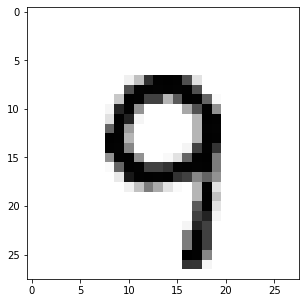

In [14]:
plt_digit(batch_x[0][0])

In [15]:
print(y_train_updated.shape)
print(batch_y.shape)
print(batch_actual.shape)

(60000, 10)
(600, 100, 10)
(600, 100)


In [16]:
y_train_updated_shuff[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [17]:
batch_y[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float128)

In [18]:
y_train_shuff[0]

9

In [19]:
batch_actual[0][0]

9

In [20]:
y_train[0]

5

In [21]:
np.random.seed(1)

initial_b = np.random.uniform(0, 0.001, n_output)
print(initial_b.shape)
print(initial_b)

initial_w = np.random.uniform(0, 0.001, n_output*n_input).reshape(10,784)
print(initial_w.shape)
print(initial_w)

def forward_pass(data_x, bias_arr, weight_mat):
    """
    data_x should be two dimensional, where data_x[i] has 784 values for each sample i
    """
    Z = np.array([bias_arr + np.sum(np.multiply(weight_mat, data_x[i]), axis = 1) for i in range(data_x.shape[0])], dtype=np.float128)        
    return Z

def softmax(Z):
    e_x = np.exp(Z)
    S = np.array([e_x[i]/np.sum(e_x[i]) for i in range(e_x.shape[0])])
    return S  

def get_max_index(data):
    n_j = data.shape[0]
    n_i = data.shape[1]
    lst = np.array([list(data[j]).index(max(data[j])) for j in range(n_j)])
    return lst

def check_accuracy(predicted, expected):
    batch_acc = sklearn.metrics.accuracy_score(predicted, expected)
    return batch_acc

def cross_entropy(data_actual, softmax_data):
    CE = []
    for i in range(softmax_data.shape[0]):
        CE.append(-np.log(softmax_data[i][data_actual[i]]))
    return CE

def deriv_logit(actual, prob_data):
    lr_deriv_loss_lst = []
    n_output = 10
    for i in range(n_output):
        lr_deriv_loss_lst.append(i)
        prob_i = prob_data[i]   
        if actual == i:
            lr_deriv_loss_lst[i] = prob_i - 1
        else:
            lr_deriv_loss_lst[i] = prob_i
    return lr_deriv_loss_lst



(10,)
[4.17022005e-04 7.20324493e-04 1.14374817e-07 3.02332573e-04
 1.46755891e-04 9.23385948e-05 1.86260211e-04 3.45560727e-04
 3.96767474e-04 5.38816734e-04]
(10, 784)
[[4.19194514e-04 6.85219500e-04 2.04452250e-04 ... 3.57511167e-04
  3.30276937e-04 6.97368876e-04]
 [2.68650124e-04 8.08278014e-04 2.95288794e-04 ... 7.65183957e-04
  5.68152543e-04 6.66188090e-04]
 [1.07813901e-04 8.42830514e-05 6.25121068e-04 ... 5.73561083e-04
  9.05377380e-04 3.47413933e-04]
 ...
 [2.10073853e-04 2.26801116e-04 4.57388676e-04 ... 4.69515750e-04
  3.84104101e-04 6.75198447e-04]
 [9.53945889e-05 1.61804875e-04 9.69143921e-04 ... 1.88520463e-05
  4.72346213e-04 9.38995130e-04]
 [3.25574819e-04 3.22153019e-04 5.20307238e-05 ... 2.47718753e-04
  1.23078052e-04 1.26350470e-04]]


In [22]:
lr = 0.001

accuracy = []
cross_ent = []
batch_cross_ent = []
num_epoch = 20
for n_epoch in range(num_epoch):
    l_pred = []
    
    print("Epoch ", n_epoch+1)
    
    #shuffle at batch level
    batch_x_shuff = batch_x[:]
    batch_y_shuff = batch_y[:]
    batch_actual_shuff = batch_actual[:]
    
    batch_x_shuff, batch_y_shuff, batch_actual_shuff = shuffle(batch_x_shuff, batch_y_shuff, batch_actual_shuff, n_epoch)
    
    for n_batch in range(np.array(batch_x_shuff).shape[0]):
        Zs = forward_pass(batch_x_shuff[n_batch], initial_b, initial_w) 
        Ss = softmax(Zs) 
        
        pred_ys = get_max_index(Ss)
        l_pred.append(pred_ys)
        #print("Accuracy of batch", n_batch, ":",check_accuracy(pred_ys, batch_actual[n_batch]))

        batch_cross_ent.append(cross_entropy(batch_actual_shuff[n_batch], Ss))
        #print("Cross entropy loss of batch", n_batch, ":", cross_entropy(batch_actual_shuff[n_batch], Ss))
        
        dLs = np.array([deriv_logit(batch_actual_shuff[n_batch][j], Ss[j]) for j in range(Ss.shape[0])])
        #print("Dimension of derivative wrt logits for all examples in a single batch is ", dLs.shape)
        #print(batch_actual[i].shape)

        sum_dBs = np.sum(dLs, axis = 0)
        #print(sum_dBs)

        #print("Dimension of derivative wrt biases for all examples in a single batch is ", dBs.shape)
        #print("Dimension of sum of dBs columnwise for all examples in a single batch is ", sum_dBs.shape)

        updated_bias = initial_b - lr*sum_dBs
        #print("Initial biases are \n", initial_b)
        #print("Updated biases are \n", updated_bias)

        sum_dWs = np.sum(np.array([np.outer(dLs[i], batch_x_shuff[n_batch][i]) for i in range(dLs.shape[0])]), axis = 0)
        #print("Dimension of initial weights is ", initial_w.shape)
        #print("Dimension of sum of dWs columnwise for all examples in a single batch is ", sum_dWs.shape)

        updated_weights = initial_w -lr*sum_dWs
        #print("Initial weights are \n", initial_w[0])
        #print("Updated weights are \n", updated_weights[0])
        #print("Check if initial weights equal to updated weights: ", all(initial_w[0] == updated_weights[0]))

        initial_b = updated_bias
        initial_w = updated_weights
    accuracy.append(check_accuracy(np.array(l_pred).flatten(), np.array(batch_actual_shuff).flatten()))
    cross_ent.append(np.average(batch_cross_ent))
    #print("Accuracy is", accuracy[n_epoch])
    #print("Cross entropy loss is", cross_ent[n_epoch])
    

Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20


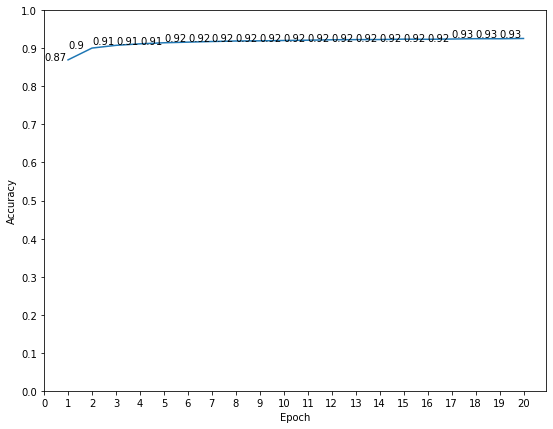

In [43]:
plt.figure(figsize = (9,7))
plt.plot([i+1 for i in range(num_epoch)], accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0, num_epoch+1, step= 1))
plt.yticks(ticks = np.arange(0, np.max(accuracy)*1.4, step= 0.1))
plt.ylim(0, 1)

for index, value in enumerate(accuracy):
    value = float("{:.2f}".format(value))
    plt.text(index, value, str(value))
    

(0, 0.6417269824616353818)

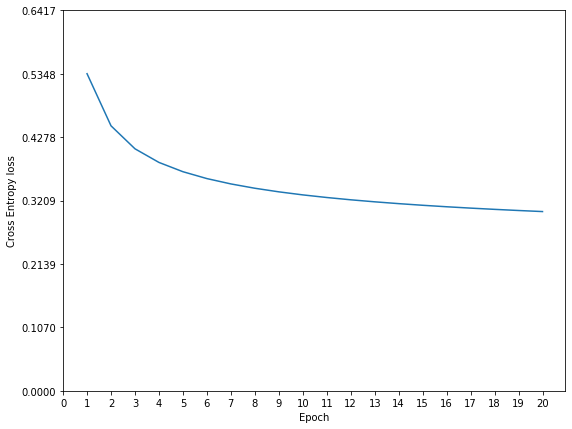

In [24]:
plt.figure(figsize = (9,7))
plt.plot([i+1 for i in range(num_epoch)], cross_ent)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy loss")
plt.xticks(np.arange(0, num_epoch+1, step= 1))
max_CE = np.max(cross_ent)
plt.yticks(np.arange(0, max_CE*1.4, step= (max_CE*2)/10))
plt.ylim(0, np.max(cross_ent)*1.2)